In [2]:
import json

import nptsne
import numpy as np
from nptsne import hsne_analysis
import pandas as pd

### THERE ARE NO CliffDiving ACTIONS -> So 19 + 1 classes

In [3]:
X = np.load("C:\\Users\\alexa\\Desktop\\Thumos14\\features_perfect_noise.npy")
GT_LABELS = pd.read_csv("C:\\Users\\alexa\\Desktop\\Thumos14\\labels_test_set_gt.csv", header=0)
# print(labels.iloc[0]["segment_gt_label"])

### Create HSNE with 4 scales

In [4]:
def create_hsne(scales = 4):
    print(f'Size data: {X.shape}')
    hsne = nptsne.HSne(True)
    hsne.create_hsne(X, scales)
    print(f'Num scales: {hsne.num_scales} Num points {hsne.num_data_points}')
    return hsne

In [5]:
def create_top_analysis(hsne):
    top_analysis = nptsne.hsne_analysis.Analysis(hsne,nptsne.hsne_analysis.EmbedderType.GPU)
    for i in range(500):
        top_analysis.do_iteration()
    return top_analysis

In [6]:
def create_new_analysis(hsne, points, parent_analysis, iterations = 500):
    new_analysis = nptsne.hsne_analysis.Analysis(hsne, embedder_type= nptsne.hsne_analysis.EmbedderType.GPU, parent=parent_analysis, parent_selection=points)
    for i in range(iterations):
        new_analysis.do_iteration()
    return new_analysis

In [7]:
import matplotlib.pyplot as plt

def plot_analysis(analysis):
    x_coords = [point[0] for point in analysis.embedding]
    y_coords = [point[1] for point in analysis.embedding]
    
    # Create scatter plot
    plt.scatter(x_coords, y_coords, s=5, color='blue')
    
    plt.grid(True)  # Enable grid
    plt.show()


In [8]:
from sklearn.cluster import AgglomerativeClustering
def create_clustering(analysis, n_clusters):
    points = analysis.embedding
    agglomerativeClustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
    agglomerativeClustering.fit(points)
    return agglomerativeClustering

In [9]:
hsne = create_hsne(4)
top_analysis = create_top_analysis(hsne)

Size data: (337180, 21)
Num scales: 4 Num points 337180


C:\Users\alexa\anaconda3\envs\HSNE\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


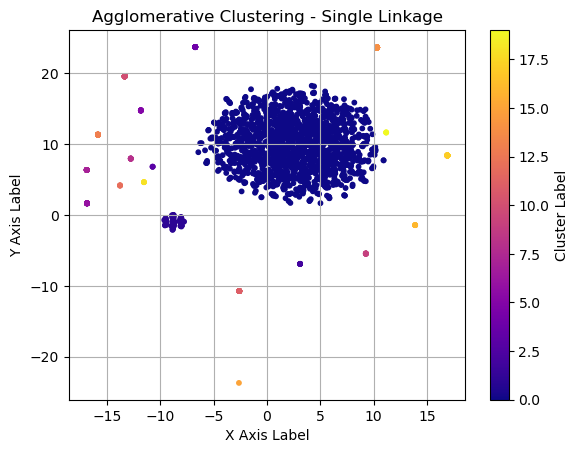

In [9]:
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN, KMeans, MeanShift, SpectralClustering, AgglomerativeClustering
points = top_analysis.embedding
# dbscan = DBSCAN(eps=3, min_samples=2)  # Adjust parameters as needed
# dbscan.fit(points)
# optics = OPTICS(min_samples=200)
# optics.fit(points)
# hdb = HDBSCAN(min_cluster_size=30)
# hdb.fit(points)
kmeans = KMeans(n_init = "auto", n_clusters=20)
kmeans.fit(points)
mean_shift = MeanShift()
mean_shift.fit(points)
spectralClustering = SpectralClustering(n_clusters=20)
spectralClustering.fit(points)
agglomerativeClustering = AgglomerativeClustering(n_clusters=20, linkage="single")
agglomerativeClustering.fit(points)

# Retrieve cluster labels
# cluster_labels_dbscan = dbscan.labels_
# cluster_labels_optics = optics.labels_ 
# cluster_labels_hdb = hdb.labels_
cluster_labels_kmeans = kmeans.labels_
cluster_labels_meanshift = mean_shift.labels_
cluster_labels_spectralClustering = spectralClustering.labels_
cluster_labels_agglomerativeClustering = agglomerativeClustering.labels_


plt.scatter(points[:, 0], points[:, 1], c=cluster_labels_agglomerativeClustering, cmap='plasma', s=10)
plt.title('Agglomerative Clustering - Single Linkage')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [197]:
from sklearn.metrics.cluster import contingency_matrix
gt_labels_top_scale = GT_LABELS[GT_LABELS["segment_id"].isin(top_analysis.landmark_orig_indexes)]
contingency_matrix = contingency_matrix(gt_labels_top_scale["segment_gt_label"], cluster_labels_agglomerativeClustering)
# Fix the indexing
contingency_matrix_df = pd.DataFrame(contingency_matrix, 
                               index=pd.unique(gt_labels_top_scale["segment_gt_label"]), 
                               columns=range(20))

file_path = 'contingency_matrix_test_3.xlsx'
contingency_matrix_df.to_excel(file_path)

print("Confusion matrix saved to:", file_path)

Confusion matrix saved to: contingency_matrix_test_3.xlsx


In [17]:
from sklearn import metrics
def calculate_purity(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [18]:
def get_true_labels_for_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]

In [19]:
def find_number_of_gt_labels_in_analysis(analysis):
    original_indexes = analysis.landmark_orig_indexes
    return len(pd.unique(GT_LABELS[GT_LABELS["segment_id"].isin(original_indexes)]["segment_gt_label"]))

In [20]:
class ComparableAnalysis:
    def __init__(self, number_of_points, analysis):
        self.number_of_points = number_of_points
        self.analysis = analysis
    
    def __lt__(self, other):
        return self.number_of_points < other.number_of_points
    
    def __eq__(self, other):
        return self.analysis.id == other.analysis.id

In [38]:
from collections import defaultdict
import queue

def bfs(hsne, top_analysis, always_most_points = False):
    purities_per_scale = defaultdict(list)
    annotated_amount = []
    if always_most_points:
        queue_analysis = queue.PriorityQueue()
    else:
        queue_analysis = queue.Queue()
    queue_analysis.put(ComparableAnalysis(top_analysis.number_of_points, top_analysis))
    while not queue_analysis.empty():
        current_analysis = queue_analysis.get().analysis
        if current_analysis.scale_id == 0:
            annotated_amount.append(current_analysis.number_of_points)
        else:
            annotated_amount.append(0)
        amount_of_labels = find_number_of_gt_labels_in_analysis(current_analysis)
        if amount_of_labels > 0 and current_analysis.number_of_points > 1:
            clustering = create_clustering(current_analysis, amount_of_labels)
            true_labels = get_true_labels_for_analysis(current_analysis)
            purity = calculate_purity(true_labels,clustering.labels_)
            purities_per_scale[current_analysis.scale_id].append(purity)
            if current_analysis.scale_id != 0:
                for label in np.unique(clustering.labels_):
                    new_points = np.where(clustering.labels_ == label)[0]
                    iterations = 500
                    # if len(new_points) < 50:
                    #     iterations = 50
                    temp_analysis = create_new_analysis(hsne,new_points.tolist(),current_analysis, iterations)
                    #multiplied by -1 so I get inverse order for the PriorityQueue
                    queue_analysis.put(ComparableAnalysis(-1 * temp_analysis.number_of_points, temp_analysis))
    print(purities_per_scale)
    print(annotated_amount)
    return purities_per_scale, annotated_amount

            
            
        
        
    

In [39]:
import json
purities, annotated_amount = bfs(hsne, top_analysis, always_most_points=False)
with open("C:\\msc\\msc\\Experiments_output\\Amounts_test_features_4_scales_last_level.json", "w") as file:
    json.dump(annotated_amount, file)
# with open("C:\\msc\\msc\\Experiments_output\\Purity_test_features_5_scales.json", "w") as file:
#     json.dump(purities, file)

[]
[   0    1    2    3  350  351  352  353  354  355  356  357  358  359
  360  361  362  363  364  365  366  367  410  411  552  553  678  679
  829  830  831 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061]
DONE
[  23   27   28   29   30   31   32   33   34   35   36   50   55   56
   59   60   61   62   63   64   65   66   67   68   69   70   71   72
   82   83   84   85   86   87   88   89   90   93   94   95   97   98
   99  100  101  102  103  104  105  106  107  110  111  123  124  125
  126  127  128  129  130  131  132  133  134  135  136  137  138  139
  140  141  142  149  150  153  154  155  156  157  158  161  163  164
  165  181  182  187  210  211  212  213  214  215  216  217  218  219
  220  221  222  223  255  256  257  258  260  261  262  263  264  265
  266  268  269  270  271  272  273  274  275  277  278  279  280  281
  282  283  284  285  286  287  288  289  290  291  292  293  295  296
  297  299  300  301  302  303  304  308  309  310  311  314  315  316
  

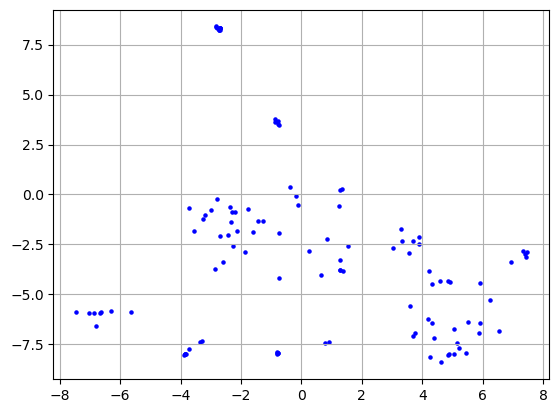

In [130]:
# new_analysis = nptsne.hsne_analysis.Analysis(hsne,nptsne.hsne_analysis.EmbedderType.GPU, parent = top_analysis, parent_selection=indexes)
# for i in range(1000):
#     new_analysis.do_iteration()
#     
# import matplotlib.pyplot as plt
# x_coords = [point[0] for point in new_analysis.embedding]
# y_coords = [point[1] for point in new_analysis.embedding]
# 
# # Create scatter plot
# plt.scatter(x_coords, y_coords, s=5, color='blue')
# 
# plt.grid(True)  # Enable grid
# plt.show()

In [20]:
# hsne.save("save_test.hsne")


[0.7875457875457875, 0.8328939230280644, 0.826684442853377, 0.8814527772776997]


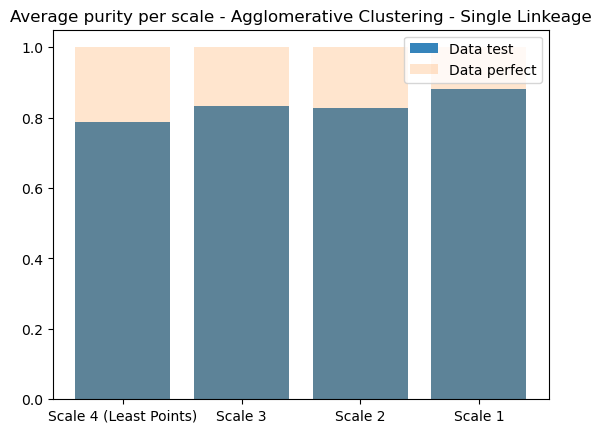

In [234]:
data_test = []
data_perfect = [1,1,1,1]
indexes = ["Scale 4 (Least Points)","Scale 3","Scale 2", "Scale 1"]

with open("C:\\msc\\msc\\Experiments_output\\Purity_test_features_5_scales.txt", "r") as file:
    data = json.load(file)
    for i in range(4,0,-1):
        data_test.append(np.mean(data[f"{i}"]))
        
print(data_test)    

plt.bar(indexes, data_test, alpha=0.9, label='Data test')
plt.bar(indexes, data_perfect, alpha=0.2, label='Data perfect')

plt.legend(loc='upper right') 
plt.title('Average purity per scale - Agglomerative Clustering - Singmaigle Linkeage') 
plt.show()

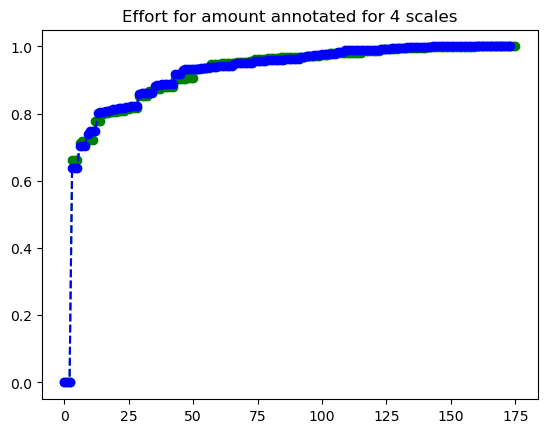

In [40]:
import json

x_perfect = []
y_perfect = []
x_test = []
y_test = []
with open("C:\\msc\\msc\\Experiments_output\\Amounts_perfect_features_4_scales_last_level.json", "r") as file:
    data = json.load(file)
    total = np.sum(data)
    c = 0
    for i, val in enumerate(data):
        c += val
        x_perfect.append(i)
        y_perfect.append(c/total)

with open("C:\\msc\\msc\\Experiments_output\\Amounts_test_features_4_scales_last_level.json", "r") as file:
    data = json.load(file)
    total = np.sum(data)
    c = 0
    for i, val in enumerate(data):
        c += val
        x_test.append(i)
        y_test.append(c/total)
    plt.title("Effort for amount annotated for 4 scales")
    plt.plot(x_perfect,y_perfect,"go--")
    plt.plot(x_test,y_test, "bo--")